In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sys
import copy
import os
from sklearn.model_selection import train_test_split
from sklearn.datasets import fetch_california_housing
from scipy.linalg import block_diag, inv
from sklearn.model_selection import GroupKFold
from sklearn.linear_model import SGDRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GroupKFold
from sklearn.svm import SVR
from sklearn.decomposition import PCA
from sklearn.utils import shuffle
import scipy.stats
from scipy.stats import t, zscore, multivariate_normal
import pickle
import time
#import statsmodels.api as sm
#import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import tracemalloc
import seaborn as sns
from sklearn.metrics import mean_squared_error
from sklearn.datasets import make_regression
from google.colab import files

In [ ]:
class ARLMM_Model:
    def __init__(self):
        pass

    def mapping_matrix_T(self, measurement):
        """
        Get mapping matrix to map cross-sectional variables to longitudinal information.
        """
        T = np.expand_dims(np.repeat(1, measurement[0]), axis=1)
        for i in range(1, len(measurement)):
            T = block_diag(T, np.expand_dims(np.repeat(1, measurement[i]), axis=1))
        return T

    def cross_sectional_longit_mapping_function(self, matrix_T, correlation_matrix):
        """
        Map cross-sectional covariate information or random effect correlation information to longitudinal.
        """
        T_correlation = np.matmul(matrix_T, correlation_matrix)
        T_correlation_T_transpose = np.matmul(T_correlation, np.transpose(matrix_T))
        longit_correlation = T_correlation_T_transpose
        return longit_correlation

    def load_groups_from_file(self, measurement):
        """
        Create group information for cross-validation based on measurements.
        """
        k = 0
        groups = []
        for cnt_meas in measurement:
            groups.extend([k] * cnt_meas)
            k += 1
        groups = np.array(groups)
        print(groups)
        return groups

    def load_random_effect_info_from_file(self, grm, measurement, subject_level, T):
        """
        Get the random effect covariance matrices.
        """
        # Create longitudinal GRM
        grm_arr = np.array(grm)
        longit_grm = self.cross_sectional_longit_mapping_function(T, grm_arr)

        # Create measurement error info
        longit_error = np.identity(np.sum(measurement))

        # Create temporal or spatially correlated random effect matrices
        if measurement is not None:
            # Initialize C1 and C2
            longit_C1 = np.zeros((measurement[0], measurement[0]))
            longit_C2 = np.zeros((measurement[0], measurement[0]))
            for i in range(measurement[0]):
                for j in range(measurement[0]):
                    if abs(i - j) == 1:
                        longit_C1[i, j] = 1
                    if abs(i - j) == 2:
                        longit_C2[i, j] = 1

            for s in range(1, len(measurement)):
                longit_C1_temp = np.zeros((measurement[s], measurement[s]))
                longit_C2_temp = np.zeros((measurement[s], measurement[s]))
                for i in range(measurement[s]):
                    for j in range(measurement[s]):
                        if abs(i - j) == 1:
                            longit_C1_temp[i, j] = 1
                        if abs(i - j) == 2:
                            longit_C2_temp[i, j] = 1
                longit_C1 = block_diag(longit_C1, longit_C1_temp)
                longit_C2 = block_diag(longit_C2, longit_C2_temp)

            # Create site effect matrix if subject_level is not None
            if subject_level is not None:
                subject_level_dummy = pd.get_dummies(subject_level)
                subject_level_cnt = subject_level_dummy.sum(axis=0)
                block_diag_matrix = np.identity(subject_level_cnt.iloc[0])
                for i in range(1, len(subject_level_cnt)):
                    block_diag_matrix = block_diag(block_diag_matrix, np.identity(subject_level_cnt.iloc[i]))
                longit_block_diag_matrix = self.cross_sectional_longit_mapping_function(T, block_diag_matrix)
                return longit_grm, longit_C1, longit_C2, longit_block_diag_matrix, longit_error
            else:
                return longit_grm, longit_C1, longit_C2, longit_error
        else:
            return longit_grm, longit_error

    def safe_inverse(self, X, lambda_value=0.01):
      XX = np.dot(X.T, X)

      try:
          # Attempt to compute the inverse of XX
          XX_inv = inv(XX)
          #print("Matrix is invertible, using regular inverse.")

      except np.linalg.LinAlgError as err:
          # If non-invertible, add lambda_value to the diagonal and compute the regularized inverse
          print("Matrix is non-invertible, using regularized inverse with lambda =", lambda_value)
          I = np.identity(XX.shape[0])
          XX_inv = inv(XX + lambda_value * I)

      return XX_inv

    def project_covariate_func(self, X):
        """
        Get the projection matrix for covariates.
        """
        XX = np.dot(np.transpose(X), X)
        Z = np.dot(X, self.safe_inverse(XX))
        P = np.identity(X.shape[0]) - np.dot(Z, np.transpose(X))
        return P

    def fit(self, Y, X, grm, measurement, subject_level=None):
        """
        Fit the ARLMM model.
        """
        T = self.mapping_matrix_T(measurement)
        P = self.project_covariate_func(X)
        Y_Y_transpose_1d = np.reshape(np.dot(Y, np.transpose(Y)), [-1, 1], order='F')

        if subject_level is not None:
            longit_grm, longit_C1, longit_C2, longit_block_diag_matrix, longit_error = self.load_random_effect_info_from_file(grm, measurement, subject_level, T)
            project_longit_grm_1d = np.reshape(self.cross_sectional_longit_mapping_function(P, longit_grm), [-1, 1], order='F')
            project_longit_C1_1d = np.reshape(self.cross_sectional_longit_mapping_function(P, longit_C1), [-1, 1], order='F')
            project_longit_C2_1d = np.reshape(self.cross_sectional_longit_mapping_function(P, longit_C2), [-1, 1], order='F')
            project_longit_block_diag_matrix_1d = np.reshape(self.cross_sectional_longit_mapping_function(P, longit_block_diag_matrix), [-1, 1], order='F')
            project_longit_error_1d = np.reshape(self.cross_sectional_longit_mapping_function(P, longit_error), [-1, 1], order='F')

            project_longit_X_1d = np.concatenate((project_longit_grm_1d, project_longit_C1_1d, project_longit_C2_1d, project_longit_block_diag_matrix_1d, project_longit_error_1d), axis=1)

            #clf = SGDRegressor(tol=1e-3, penalty='l2', loss='epsilon_insensitive', fit_intercept=False, early_stopping=True)
            clf = SGDRegressor(tol=1e-3, penalty='l2', loss='huber', fit_intercept=False, early_stopping=False)
            clf.fit(project_longit_X_1d, Y_Y_transpose_1d.ravel())

            sigma = clf.coef_
            rho_est = max(1e-11, min(sigma[2]/sigma[1], 1))
            var_t_est = max(0.5 * sigma[1] / rho_est + 0.5 * sigma[2] / (rho_est ** 2), 1e-11)
            var_g_est = max(sigma[0], 1e-11)
            var_c_est = max(sigma[3], 1e-11)
            var_e_est = max(sigma[4] - var_t_est, 1e-11)
            h2_est = var_g_est / (var_t_est + var_g_est + var_c_est + var_e_est)

            t_error_cov = var_t_est * (np.identity(T.shape[0]) + rho_est * longit_C1 + rho_est ** 2 * longit_C2)
            error_cov = var_e_est * np.identity(T.shape[0])
            genetic_cov = var_g_est * longit_grm
            correlation_cov = var_c_est * longit_block_diag_matrix
            total_V = t_error_cov + error_cov + genetic_cov + correlation_cov

            Y_new = np.dot(inv(total_V), Y)
            response_new = np.dot(np.transpose(X), Y_new)
            X_new = np.dot(inv(total_V), X)
            predictor_new = np.dot(np.transpose(X), X_new)
            beta_est = np.dot(inv(predictor_new), response_new)

            self.rho_est = rho_est
            self.var_g_est = var_g_est
            self.var_t_est = var_t_est
            self.var_c_est = var_c_est
            self.var_e_est = var_e_est
            self.h2_est = h2_est
            self.beta_est = beta_est

        else:
            longit_grm, longit_C1, longit_C2, longit_error = self.load_random_effect_info_from_file(grm, measurement, subject_level, T)
            project_longit_grm_1d = np.reshape(self.cross_sectional_longit_mapping_function(P, longit_grm), [-1, 1], order='F')
            project_longit_C1_1d = np.reshape(self.cross_sectional_longit_mapping_function(P, longit_C1), [-1, 1], order='F')
            project_longit_C2_1d = np.reshape(self.cross_sectional_longit_mapping_function(P, longit_C2), [-1, 1], order='F')
            project_longit_error_1d = np.reshape(self.cross_sectional_longit_mapping_function(P, longit_error), [-1, 1], order='F')

            project_longit_X_1d = np.concatenate((project_longit_grm_1d, project_longit_C1_1d, project_longit_C2_1d, project_longit_error_1d), axis=1)

            clf = SGDRegressor(tol=1e-3, penalty='l2', loss='epsilon_insensitive', fit_intercept=False, early_stopping=False)
            #clf = SGDRegressor(tol=1e-3, penalty='l2', loss='huber', fit_intercept=False, early_stopping=False)
            clf.fit(project_longit_X_1d, Y_Y_transpose_1d.ravel())

            sigma = clf.coef_
            rho_est = max(1e-11, min(sigma[2]/sigma[1], 1))
            var_t_est = max(0.5 * sigma[1] / rho_est + 0.5 * sigma[2] / (rho_est ** 2), 1e-11)
            var_g_est = max(sigma[0], 1e-11)
            var_e_est = max(sigma[3] - var_t_est, 1e-11)
            h2_est = var_g_est / (var_t_est + var_g_est + var_e_est)

            t_error_cov = var_t_est * (np.identity(T.shape[0]) + rho_est * longit_C1 + rho_est ** 2 * longit_C2)
            error_cov = var_e_est * np.identity(T.shape[0])
            genetic_cov = var_g_est * longit_grm
            total_V = t_error_cov + error_cov + genetic_cov

            Y_new = np.dot(inv(total_V), Y)
            response_new = np.dot(np.transpose(X), Y_new)
            X_new = np.dot(inv(total_V), X)
            predictor_new = np.dot(np.transpose(X), X_new)
            beta_est = np.dot(inv(predictor_new), response_new)

            self.rho_est = rho_est
            self.var_g_est = var_g_est
            self.var_t_est = var_t_est
            self.var_e_est = var_e_est
            self.h2_est = h2_est
            self.beta_est = beta_est

        return self  # For method chaining

In [ ]:
class GenomeSimulator:
    def __init__(self, n_individuals, n_loci, maf_range=(0.05, 0.5), population_structure=False, n_subpopulations=2):
        """
        Initializes the class with the number of individuals, loci, and other parameters (cross sectional).

        n_individuals: Number of individuals
        n_loci: Number of loci (genetic markers)
        maf_range: Tuple (min_maf, max_maf) specifying the range of MAF to simulate
        population_structure: Whether to simulate population structure
        n_subpopulations: Number of subpopulations (if population structure is enabled)
        """
        self.n_individuals = n_individuals
        self.n_loci = n_loci
        self.maf_range = maf_range
        self.population_structure = population_structure
        self.n_subpopulations = n_subpopulations
        self.subpop_labels = None
        self.genotype_matrix = None
        self.beta_values = None
        self.fixed_snp = None  # For the single SNP used as a fixed effect
        self.fixed_snp_beta = None  # Effect size for the fixed SNP

    def simulate_allele_freqs(self):
        """
        Simulates allele frequencies within the specified MAF range for each locus.
        """
        min_maf, max_maf = self.maf_range
        return np.random.uniform(min_maf, max_maf, self.n_loci)

    def simulate_genotype_data(self):
        """
        Simulates genotype data with optional population structure.
        return: Genotype matrix (n_individuals x n_loci)
        """
        if self.population_structure:
            return self._simulate_with_population_structure()
        else:
            return self._simulate_without_population_structure()

    def _simulate_without_population_structure(self):
        """
        Simulates genotype data without population structure.
        return: Genotype matrix (n_individuals x n_loci)
        """
        allele_freqs = self.simulate_allele_freqs()
        G = np.zeros((self.n_individuals, self.n_loci))

        for i in range(self.n_loci):
            p = allele_freqs[i]  # Frequency of the alternative allele p
            G[:, i] = np.random.binomial(2, p, size=self.n_individuals)  # Simulate genotypes (0, 1, or 2)

        self.genotype_matrix = G
        return G

    def _simulate_with_population_structure(self): # FST of 0.01
        """
        Simulates genotype data with population structure, dividing individuals into subpopulations.
        return: Genotype matrix (n_individuals x n_loci)
        """
        # Assign individuals to subpopulations
        self.subpop_labels = np.random.choice(self.n_subpopulations, size=self.n_individuals)

        G = np.zeros((self.n_individuals, self.n_loci))
        allele_freqs_global = self.simulate_allele_freqs()  # Global allele frequencies

        # Adjust allele frequencies for each subpopulation
        for i in range(self.n_loci):
            for subpop in range(self.n_subpopulations):
                # Modify allele frequencies for each subpopulation (slightly different from global)
                allele_freqs_subpop = np.clip(allele_freqs_global[i] + np.random.normal(0, 0.05), 0.05, 0.95)
                # Simulate genotypes for individuals in the current subpopulation
                G[self.subpop_labels == subpop, i] = np.random.binomial(2, allele_freqs_subpop, size=(self.subpop_labels == subpop).sum())

        self.genotype_matrix = G
        return G

    def simulate_fixed_snp(self):
        """
        Simulates a single SNP to be used as a fixed effect.
        return: Genotype array (n_individuals) for the fixed SNP
        """
        maf = np.random.uniform(*self.maf_range)  # Minor allele frequency for the fixed SNP
        self.fixed_snp = np.random.binomial(2, maf, size=self.n_individuals)  # Simulate genotypes (0, 1, or 2)
        return self.fixed_snp


    def generate_beta_values(self, effect_distribution='normal', population_specific=False):
        """
        Generates beta values for each locus, optionally considering population structure.

        effect_distribution: Distribution of the effect sizes ('normal' or 'uniform')
        population_specific: If True, generates different beta values for each subpopulation
        return: Beta values (1D array for global, 2D array if population-specific)
        """
        if effect_distribution == 'normal':
            # Generate effect sizes from a normal distribution (mean = 0, std = 1)
            base_beta_values = np.random.normal(0, 1, self.n_loci)
        elif effect_distribution == 'uniform':
            # Generate effect sizes from a uniform distribution (-1, 1)
            base_beta_values = np.random.uniform(-1, 1, self.n_loci)
        else:
            raise ValueError("Invalid effect_distribution. Use 'normal' or 'uniform'.")

        if population_specific and self.population_structure:
            # Generate different beta values for each subpopulation
            self.beta_values = np.zeros((self.n_subpopulations, self.n_loci))
            for subpop in range(self.n_subpopulations):
                self.beta_values[subpop, :] = base_beta_values + np.random.normal(0, 0.1, self.n_loci)
        else:
            # Global beta values
            self.beta_values = base_beta_values

        return self.beta_values

    def compute_grm(self):
        """
        Computes the Genetic Relationship Matrix (GRM).
        return: Genetic Relationship Matrix (GRM)
        """
        if self.genotype_matrix is None:
            raise ValueError("Genotype matrix is not initialized. Run simulate_genotype_data first.")

        # Center genotype matrix by subtracting the mean allele frequency
        allele_means = np.mean(self.genotype_matrix, axis=0) / 2  # Mean allele frequency per locus
        G_centered = self.genotype_matrix - 2 * allele_means  # Centered genotype matrix

        # Compute the variance for each locus
        allele_variances = 2 * allele_means * (1 - allele_means)

        # Standardize the centered genotype matrix by dividing by the standard deviation
        # Avoid division by zero for variance values close to zero
        allele_variances[allele_variances == 0] = 1e-8  # Prevent division by zero
        G_standardized = G_centered / np.sqrt(allele_variances)

        # Compute the GRM as G_centered * G_centered.T / n_loci
        GRM = np.dot( G_standardized,  G_standardized.T) / self.n_loci

        return GRM

    def compute_principal_components(self, n_components=10, plot=False):
        """
        Computes the principal components (PCs) from the genotype matrix.

        n_components: Number of principal components to compute
        plot: Whether to plot the first two principal components
        return: Matrix of principal components (n_individuals x n_components)
        """
        if self.genotype_matrix is None:
            raise ValueError("Genotype matrix is not initialized. Run simulate_genotype_data first.")

        # Standardize the genotype matrix (mean 0, variance 1)
        G_standardized = (self.genotype_matrix - np.mean(self.genotype_matrix, axis=0)) / np.std(self.genotype_matrix, axis=0)

        # Perform PCA
        pca = PCA(n_components=n_components)
        self.principal_components = pca.fit_transform(G_standardized)

        # Plot if requested
        if plot:
            plt.figure(figsize=(8, 6))
            sns.scatterplot(x=self.principal_components[:, 0], y=self.principal_components[:, 1], hue=self.subpop_labels, palette='viridis', s=100)
            plt.title(f'PCA of Simulated Genotype Data (N = {self.n_individuals})')
            plt.xlabel('PC1')
            plt.ylabel('PC2')
            plt.grid(True)
            plt.show()

        return self.principal_components

In [ ]:
class LongitudinalPhenotypeSimulator:
    def __init__(self, n_individuals, repeat_measures, baseline_mean=1000, baseline_sd=100, noise_sd=50, ar1_rho=0.7):
        """
        Initializes the simulation class with parameters for longitudinal phenotypes.

        n_individuals: Number of individuals
        repeat_measures: List specifying the number of repeated measures for each individual
        baseline_mean: Mean of the baseline brain volume (or initial phenotype value)
        baseline_sd: Standard deviation of the baseline brain volume
        noise_sd: Standard deviation of noise for each measurement (controls phenotype variation)
        ar1_rho: Autoregressive correlation coefficient for AR(1) process
        """
        self.n_individuals = n_individuals
        self.repeat_measures = repeat_measures
        self.baseline_mean = baseline_mean
        self.baseline_sd = baseline_sd
        self.noise_sd = noise_sd
        self.ar1_rho = ar1_rho

        if len(repeat_measures) != n_individuals:
            raise ValueError("The length of repeat_measures must match the number of individuals.")

    def simulate_uncorrelated_phenotypes(self):
        """
        Simulates longitudinal phenotypes that are not correlated over time.
        Each time point is independent of the others.

        return: List of arrays where each array contains the simulated uncorrelated phenotypes for an individual.
        """
        phenotypes_list = []

        for i in range(self.n_individuals):
            n_measures = self.repeat_measures[i]

            # Simulate each time point independently from a normal distribution
            individual_phenotypes = np.random.normal(self.baseline_mean, self.baseline_sd, n_measures)

            # Add some noise to the measurements
            individual_phenotypes += np.random.normal(0, self.noise_sd, n_measures)

            phenotypes_list.append(individual_phenotypes)

        flattened_phenotypes_list = [item for sublist in phenotypes_list for item in sublist]

        return flattened_phenotypes_list

    def simulate_autoregressive_phenotypes(self):
        """
        Simulates longitudinal phenotypes with autoregressive correlation (AR(1)).
        The phenotypes are correlated over time with an AR(1) process.

        return: List of arrays where each array contains the simulated autoregressive phenotypes for an individual.
        """
        phenotypes_list = []

        for i in range(self.n_individuals):
            n_measures = self.repeat_measures[i]

            # Simulate the baseline (first time point)
            individual_phenotypes = np.zeros(n_measures)
            individual_phenotypes[0] = np.random.normal(self.baseline_mean, self.baseline_sd)

            # Simulate the autoregressive process for subsequent time points AR(1)
            for t in range(1, n_measures):
                # Volume at time t depends on the volume at time t-1 plus random noise
                individual_phenotypes[t] = self.ar1_rho * individual_phenotypes[t-1] + np.random.normal(0, self.noise_sd)

            phenotypes_list.append(individual_phenotypes)

        flattened_phenotypes_list = [item for sublist in phenotypes_list for item in sublist]

        return flattened_phenotypes_list

In [ ]:
class CovarianceSimulator:
    def __init__(self, n_individuals, repeat_measures):
        """
        Initializes the simulator with parameters for longitudinal data simulation.

        n_individuals: Number of individuals
        repeat_measures: Array containing the number of measurements for each individual
        """
        self.n_individuals = n_individuals
        self.repeat_measures = repeat_measures

    def generate_covariance_matrix(self, num_measures, rho=0.5):
        """
        Generate a covariance matrix with specified correlation (rho) between successive measurements.

        num_measures: Number of measurements for the covariance matrix
        rho: Correlation coefficient between successive measurements
        return: A covariance matrix
        """
        # Constructing an autoregressive covariance matrix
        cov_matrix = rho ** np.abs(np.subtract.outer(np.arange(num_measures), np.arange(num_measures)))
        return cov_matrix

    def simulate_longitudinal_data(self):
        """
        Simulates longitudinal data for a set number of subjects, each with a specified number of measurements.
        Includes dynamic covariates (Age and ICV) and a static covariate (Sex).

        return: A pandas DataFrame with simulated data
        """
        data = []

        # Static measurements (these values are generated once per individual)
        prob_female = 0.3
        sexes = np.random.binomial(1, prob_female, size=self.n_individuals)  # 1 = female, 0 = male

        for i, num_measures in enumerate(self.repeat_measures):
            age_cov_matrix = self.generate_covariance_matrix(num_measures, rho=0.8)
            icv_cov_matrix = self.generate_covariance_matrix(num_measures, rho=0.5)

            # Simulate baseline and increments for age and ICV
            initial_age = np.random.randint(20, 60)
            initial_icv = np.random.normal(1400, 100)
            age_increments = multivariate_normal.rvs(mean=np.linspace(0, num_measures - 1, num_measures), cov=age_cov_matrix)
            icv_values = multivariate_normal.rvs(mean=np.full(num_measures, initial_icv), cov=icv_cov_matrix)

            ages = initial_age + age_increments
            icvs = icv_values

            # Generate measurements with no specified correlation (for simplicity)
            measurements = np.random.normal(100 - 0.5 * ages, 5, num_measures)  # Example measurement depending on age

            for time_point in range(num_measures):
                data.append([
                    i,  # Subject ID
                    time_point,  # Time Point
                    sexes[i],  # Static: Sex
                    ages[time_point],  # Dynamic: Age
                    icvs[time_point],  # Dynamic: ICV
                ])

        df = pd.DataFrame(data, columns=['SubjectID', 'TimePoint', 'Sex', 'Age', 'ICV'])
        return df

In [ ]:
def run_simulation(n_individuals, n_loci, maf_range, repeat_measures, baseline_mean, baseline_sd, noise_sd, ar1_rho, covar_dynamic_name_list, n_simulations):
    simulation_results = []
    times = []
    peak_memory_usage = []
    total_time = 0  # To track total time across all simulations

    # Loop through each simulation
    for i in range(n_simulations):
        start_time = time.time()  # Record the start time of the simulation

        # Start tracking memory allocations
        tracemalloc.start()

        # Initialize genome simulator
        simulator = GenomeSimulator(n_individuals, n_loci, maf_range, population_structure=True, n_subpopulations=2)

        # Simulate genotype data and fixed SNP effects
        genotype_data = simulator.simulate_genotype_data()
        # Add Principle Components to covariates
        principal_components = simulator.compute_principal_components(n_components=4, plot=True)

        SNP_fixed_effect = simulator.simulate_fixed_snp()

        # Compute Genetic Relationship Matrix (GRM)
        grm = simulator.compute_grm()

        # Initialize phenotype simulator
        phenotype_simulator = LongitudinalPhenotypeSimulator(n_individuals, repeat_measures, baseline_mean, baseline_sd, noise_sd, ar1_rho)

        # Simulate autoregressive longitudinal phenotypes
        autoregressive_phenotypes = phenotype_simulator.simulate_autoregressive_phenotypes()
        autoregressive_phenotypes = np.expand_dims(autoregressive_phenotypes, axis=1)

        # Initialize covariance simulator
        covariance_simulator = CovarianceSimulator(n_individuals, repeat_measures)
        df = covariance_simulator.simulate_longitudinal_data()

        # Extract covariance data (including covariance/PCs/SNP)
        #covariance_simulator_data = np.array(df[covar_dynamic_name_list])
        covariance_simulator_data = np.concatenate((np.array(df[covar_dynamic_name_list]), np.repeat(principal_components, repeat_measures, axis=0), np.repeat(SNP_fixed_effect, repeat_measures).reshape(-1, 1)), axis=1)

        # Fit ARLMM Model with simulated data
        model = ARLMM_Model()
        model.fit(autoregressive_phenotypes, covariance_simulator_data, grm, repeat_measures, subject_level=None)


        # Store the results in the results list
        model.var_c_est = model.var_c_est if hasattr(model, 'var_c_est') else 'N/A'
        simulation_results.append([model.rho_est, model.var_g_est, model.var_t_est, model.var_c_est, model.var_e_est, model.h2_est, model.beta_est])

        # Calculate the elapsed time for this simulation
        end_time = time.time()
        elapsed_time = end_time - start_time
        #total_time += elapsed_time  # Add to the total time
        times.append(elapsed_time)

        # Stop tracking memory allocations
        current, peak = tracemalloc.get_traced_memory()
        tracemalloc.stop()

        peak_memory_usage.append(peak / 10**6)  # Convert peak memory usage to MB

    # Calculate the average time for all simulations
    # average_time = total_time / n_simulations
    # return average_time, simulation_results
    return np.mean(times), np.mean(peak_memory_usage), simulation_results

In [ ]:
def main():
    # Parameters for the simulation
    n_loci = 10000  # Number of loci (genetic markers)
    n_simulations = 1  # Number of Simulations
    n_parameters = 7  # Number of parameters to estimate
    maf_range = (0.05, 0.4)  # SNP MAF range
    baseline_mean = 3000  # Mean baseline brain volume (phenotype)
    baseline_sd = 100  # Standard deviation of the baseline phenotype
    noise_sd = 50  # Standard deviation of random noise
    ar1_rho = 0.8  # Autoregressive parameter for AR(1)
    covar_dynamic_name_list = ['Age', 'Sex', 'ICV']  # Covariates

    # Vary the number of subjects (individuals) to observe the impact on running time
    subject_numbers = [200, 400, 600, 800, 1000]  # Number of subjects to test
    # subject_numbers = [2000]
    average_times = []
    average_memory_usages = []

    for n_individuals in subject_numbers:
        repeat_measures = np.repeat(3, n_individuals)  # Repeat measures for each individual
        print(f"Running simulation for {n_individuals} individuals...")

        # Run the simulation and get the average running time
        average_time, average_memory, _ = run_simulation(
            n_individuals, n_loci, maf_range, repeat_measures, baseline_mean, baseline_sd,
            noise_sd, ar1_rho, covar_dynamic_name_list, n_simulations
        )

        # Append the average time and memory usage for this number of individuals
        average_times.append(average_time)
        average_memory_usages.append(average_memory)
        print(f"Average time for {n_individuals} individuals: {average_time:.2f} seconds")
        print(f"Average peak memory usage for {n_individuals} individuals: {average_memory:.2f} MB")

    # Save the results to a CSV file
    results_df = pd.DataFrame({
        'Number of Subjects': subject_numbers,
        'Average Time (seconds)': average_times,
        'Average Memory Usage (MB)': average_memory_usages
    })

    # Define the CSV file path
    csv_file_path = '/content/simulation_results.csv'  # Save to Colab's content directory

    # Save the DataFrame to a CSV file
    results_df.to_csv(csv_file_path, index=False)
    print(f"Results saved to {csv_file_path}")

    # Download the CSV file
    files.download(csv_file_path)  # This will trigger a download prompt in Colab

    # Plot the average running time against the number of subjects using a dot plot and lines
    plt.figure(figsize=(8, 6))
    plt.scatter(subject_numbers, average_times, color='b', s=100, label='Average Running Time')  # Scatter plot (dot plot)
    plt.plot(subject_numbers, average_times, linestyle='-', color='b', label='Trend Line')  # Line plot to connect the dots
    plt.title('Average Running Time vs Number of Subjects')
    plt.xlabel('Number of Subjects')
    plt.ylabel('Average Running Time (seconds)')
    plt.grid(True)
    plt.legend()
    plt.show()

    # Plot the average peak memory usage against the number of subjects
    plt.figure(figsize=(8, 6))
    plt.scatter(subject_numbers, average_memory_usages, color='r', s=100, label='Average Peak Memory Usage')  # Scatter plot (dot plot)
    plt.plot(subject_numbers, average_memory_usages, linestyle='-', color='r', label='Trend Line')  # Line plot to connect the dots
    plt.title('Average Peak Memory Usage vs Number of Subjects')
    plt.xlabel('Number of Subjects')
    plt.ylabel('Average Peak Memory Usage (MB)')
    plt.grid(True)
    plt.legend()
    plt.show()

Running simulation for 200 individuals...


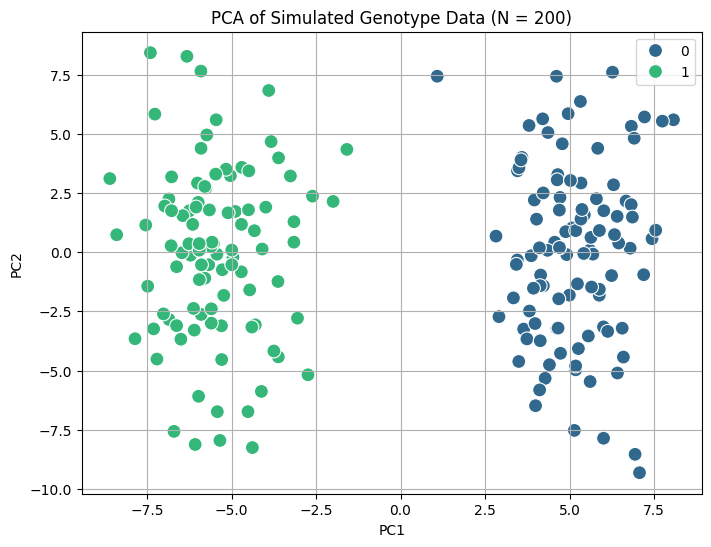

Average time for 200 individuals: 7.46 seconds
Average peak memory usage for 200 individuals: 134.87 MB
Running simulation for 400 individuals...


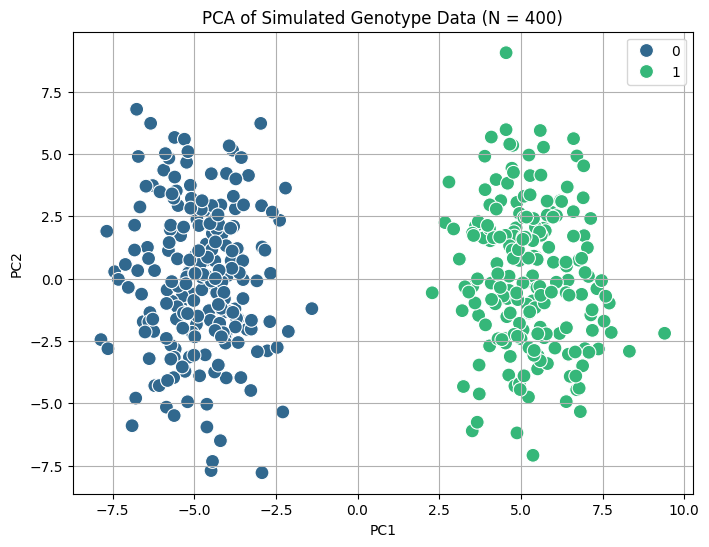

Average time for 400 individuals: 10.73 seconds
Average peak memory usage for 400 individuals: 230.72 MB
Running simulation for 600 individuals...


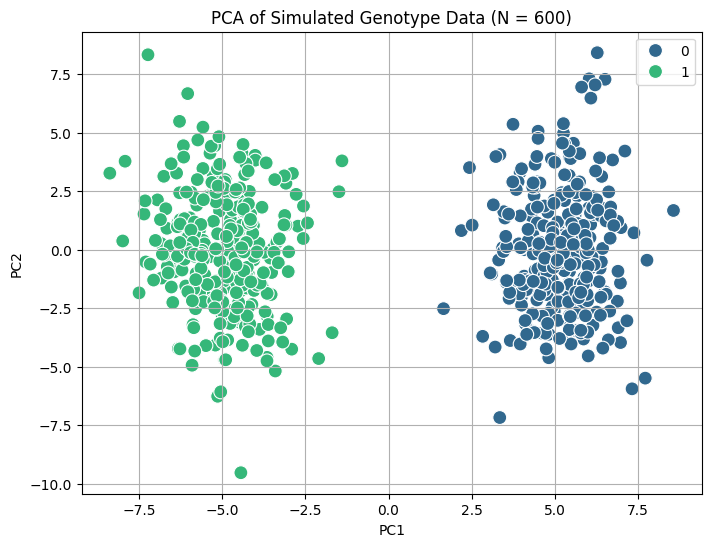

Average time for 600 individuals: 20.64 seconds
Average peak memory usage for 600 individuals: 513.45 MB
Running simulation for 800 individuals...


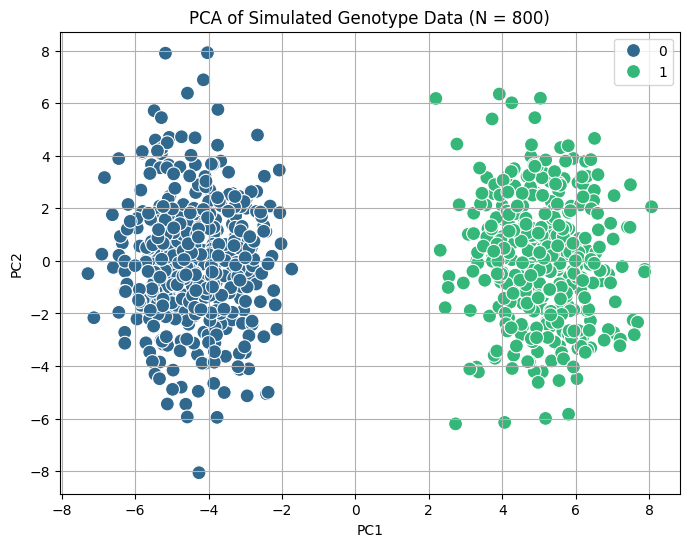

Average time for 800 individuals: 41.65 seconds
Average peak memory usage for 800 individuals: 908.31 MB
Running simulation for 1000 individuals...


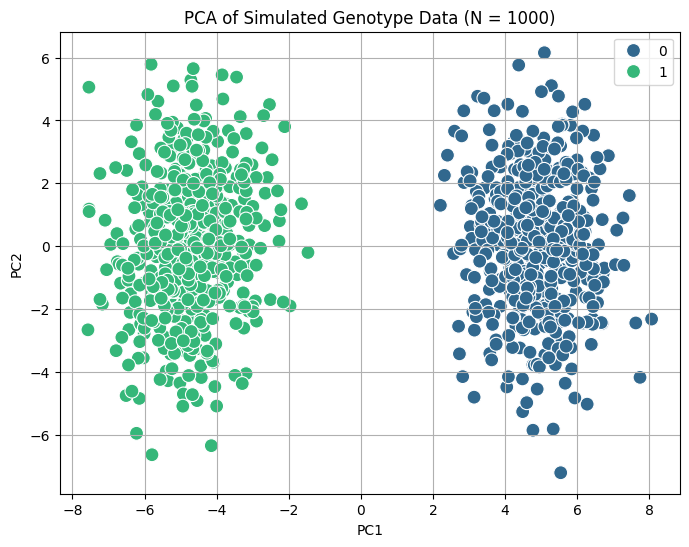

Average time for 1000 individuals: 74.83 seconds
Average peak memory usage for 1000 individuals: 1415.04 MB
Results saved to /content/simulation_results.csv


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

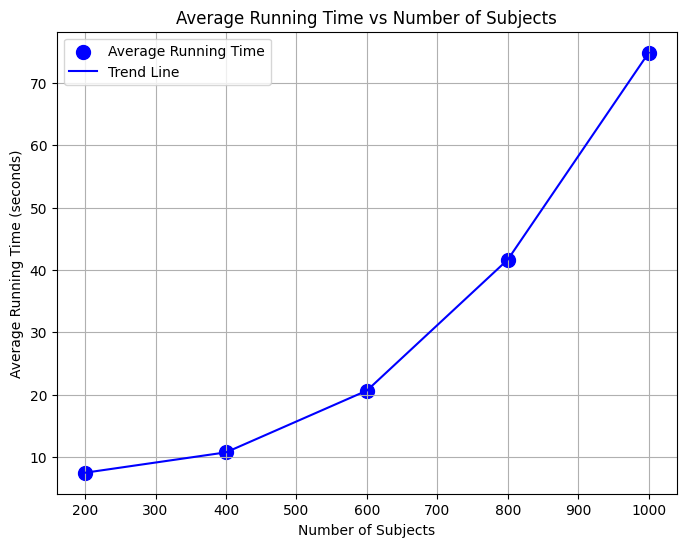

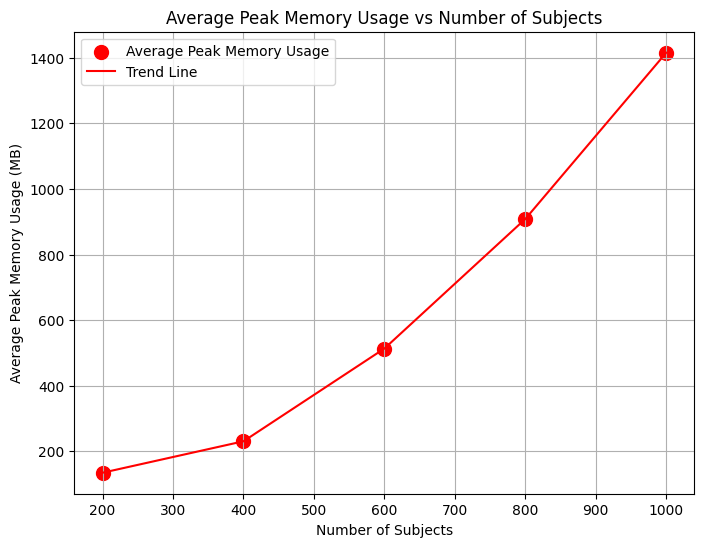

In [ ]:
main()

In [ ]:
class PermutationLMMTest:
    def __init__(self, arlmm_model, Y, X, GRM, measurement, subject_level, n_permutations=1000):
        """
        Initializes the permutation test for ARLMM Model in longitudinal data.

        Parameters:
        arlmm_model (ARLMM_Model): Instance of the ARLMM_Model class.
        Y (array): Longitudinal data ordered by time increasing per subject.
        X (array): Covariate matrix.
        GRM (array): Genetic relationship matrix for random effects.
        measurement (list): Number of measurements for each subject.
        subject_level (array): Cohort ID for each subject.
        n_permutations (int): Number of permutations.
        """
        self.arlmm_model = arlmm_model  # Instance of ARLMM_Model
        self.Y = Y
        self.X = X
        self.GRM = GRM
        self.measurement = measurement
        self.subject_level = subject_level
        self.n_permutations = n_permutations
        self.original_stat = None
        self.permuted_stats = []

    def fit_original(self):
        """
        Fit the original ARLMM model to the longitudinal data and extract the test statistic.
        """
        # Fit the ARLMM model with the original data
        self.arlmm_model.fit(self.Y, self.X, self.GRM, self.measurement, self.subject_level)

        # Store the original test statistic (e.g., heritability or fixed effect coefficient)
        #self.original_stat = self.arlmm_model.rho_est  # or other statistics such as beta coefficient
        #print(f"Original statistic (temporal/spatial autoregresive parameter): {self.original_stat}")
        self.original_stat = self.arlmm_model.h2_est
        print(f"Original statistic (h2): {self.original_stat}")

    def permute_within_subject(self, Z):
        """
        Permute the outcome Y within each subject, maintaining the longitudinal structure.
        """
        permuted_Z = Z.copy()
        start = 0
        for n_meas in self.measurement:
            # Shuffle Y values within each subject's time-series data
            permuted_Z[start:start + n_meas] = np.random.permutation(permuted_Z[start:start + n_meas])
            start += n_meas
        return permuted_Z

    def permute_outside_of_subject(self, Z):
        """
        Permute the entire blocks of Y data corresponding to subjects, maintaining the internal structure.
        """
        # Create an index array for subjects
        index_blocks = []
        start = 0
        for n_meas in self.measurement:
            index_blocks.append(np.arange(start, start + n_meas))
            start += n_meas

        # Shuffle the blocks
        np.random.shuffle(index_blocks)

        # Reorder Z (either phenotype or genotypes) based on shuffled blocks
        permuted_Z = np.concatenate([Z[block] for block in index_blocks])

        return permuted_Z


    def fit_permuted(self):
        """
        Perform the permutation test by shuffling Y and refitting the model.
        """
        for i in range(self.n_permutations):
            # Permute within subjects (preserving longitudinal structure)
            permuted_Y = self.permute_outside_of_subject(self.Y)
            permuted_X = self.permute_outside_of_subject(self.X)

            # Fit the ARLMM model on permuted Y
            self.arlmm_model.fit(permuted_Y, permuted_X, self.GRM, self.measurement, self.subject_level)
            #self.arlmm_model.fit(permuted_Y, permuted_X, self.GRM, self.measurement, self.subject_level)

            # Store the permuted test statistic (e.g., heritability or fixed effect coefficient)
            permuted_stat = self.arlmm_model.h2_est  # or use other statistics, e.g., beta coefficient
            self.permuted_stats.append(permuted_stat)

            # Optionally print progress every 100 permutations
            if (i + 1) % 100 == 0:
                print(f"Permutation {i + 1}/{self.n_permutations}, Permuted statistic: {permuted_stat}")

    def calculate_p_value(self):
        """
        Calculate the h2 values based on the permuted test statistics.

        Returns:
        float: The h2 values for the original statistic.
        """
        if self.original_stat is None:
            raise ValueError("Original model has not been fitted. Call fit_original() first.")

        # Calculate p-value: proportion of permuted stats greater than or equal to the original
        permuted_stats = np.array(self.permuted_stats)
        p_value = np.mean(np.abs(permuted_stats) >= np.abs(self.original_stat))

        print(f"P-value from permutation test: {p_value}")

        # Visualize the distribution of permuted statistics
        self.visualize_results(permuted_stats, self.original_stat)

        return p_value

    def visualize_results(self, permuted_stats, original_stat):
        """
        Visualize the distribution of permuted test statistics and the p-value.
        """
        # Plot the histogram of permuted statistics
        plt.figure(figsize=(10, 6))
        sns.histplot(permuted_stats, kde=True, color='skyblue', bins=30, label='Permuted Stats')
        plt.axvline(original_stat, color='red', linestyle='--', label='Original Statistic')
        plt.title('Distribution of Permuted Test Statistics')
        plt.xlabel('Test Statistic')
        plt.ylabel('Frequency')
        plt.legend()
        plt.show()

        # Plot the evolution of permuted statistics
        plt.figure(figsize=(10, 6))
        plt.plot(permuted_stats, color='blue', alpha=0.6, label='Permuted Test Statistics')
        plt.axhline(original_stat, color='red', linestyle='--', label='Original Statistic')
        plt.title('Evolution of Test Statistics Over Permutations')
        plt.xlabel('Permutation Index')
        plt.ylabel('Test Statistic')
        plt.legend()
        plt.show()

        # Plot the empirical CDF of permuted statistics
        plt.figure(figsize=(10, 6))
        sns.ecdfplot(permuted_stats, label='Empirical CDF of Permuted Stats', color='green')
        plt.axvline(original_stat, color='red', linestyle='--', label='Original Statistic')
        plt.title('Empirical CDF of Permuted Statistics')
        plt.xlabel('Test Statistic')
        plt.ylabel('Cumulative Probability')
        plt.legend()
        plt.show()

In [ ]:
def run_permutation_test(n_individuals, n_loci, maf_range, repeat_measures, baseline_mean, baseline_sd, noise_sd, ar1_rho, covar_dynamic_name_list, n_simulations):
    simulation_p_value_results = []

    # Loop through each simulation
    for i in range(n_simulations):
        # Initialize genome simulator
        simulator = GenomeSimulator(n_individuals, n_loci, maf_range, population_structure=False, n_subpopulations=2)

        # Simulate genotype data and fixed SNP effects
        genotype_data = simulator.simulate_genotype_data()
        # Add Principle Components to covariates
        principal_components = simulator.compute_principal_components(n_components=4, plot=True)
        print(np.shape(principal_components))

        SNP_fixed_effect = simulator.simulate_fixed_snp()
        print(np.shape(SNP_fixed_effect))

        # Compute Genetic Relationship Matrix (GRM)
        grm = simulator.compute_grm()

        # Initialize phenotype simulator
        phenotype_simulator = LongitudinalPhenotypeSimulator(n_individuals, repeat_measures, baseline_mean, baseline_sd, noise_sd, ar1_rho)

        # Simulate autoregressive longitudinal phenotypes
        autoregressive_phenotypes = phenotype_simulator.simulate_autoregressive_phenotypes()
        autoregressive_phenotypes = np.expand_dims(autoregressive_phenotypes, axis=1)

        # Initialize covariance simulator
        covariance_simulator = CovarianceSimulator(n_individuals, repeat_measures)
        df = covariance_simulator.simulate_longitudinal_data()

        # Extract covariance data (including covariance/PCs/SNP)
        print(np.shape(df[covar_dynamic_name_list]))
        #covariance_simulator_data = np.array(df[covar_dynamic_name_list])
        covariance_simulator_data = np.concatenate((np.array(df[covar_dynamic_name_list]), np.repeat(principal_components, repeat_measures, axis=0), np.repeat(SNP_fixed_effect, repeat_measures).reshape(-1, 1)), axis=1)


        # Fit ARLMM Model with simulated data
        model = ARLMM_Model()

        perm_test = PermutationLMMTest(model, autoregressive_phenotypes, covariance_simulator_data, grm, repeat_measures, subject_level=None, n_permutations=1000)

        perm_test.fit_original()
        perm_test.fit_permuted()
        simulation_p_value_results.append(perm_test.calculate_p_value())

        # Store the results in the results list
        #model.var_c_est = model.var_c_est if hasattr(model, 'var_c_est') else 'N/A'
        #simulation_results.append([model.rho_est, model.var_g_est, model.var_t_est, model.var_c_est, model.var_e_est, model.h2_est, model.beta_est])

    # Calculate the average time for all simulations
    # average_time = total_time / n_simulations
    return simulation_p_value_results

In [ ]:
def main_permutation_test():
    # Parameters for the simulation
    n_loci = 1500  # Number of loci (genetic markers)
    n_simulations = 100  # Number of Simulations?
    n_parameters = 7  # Number of parameters to estimate
    maf_range = (0.05, 0.4)  # SNP MAF range
    baseline_mean = 3000  # Mean baseline brain volume (phenotype)
    baseline_sd = 500 # Standard deviation of the baseline phenotype
    noise_sd = 50  # Standard deviation of random noise
    ar1_rho = 0.8  # Autoregressive parameter for AR(1)
    covar_dynamic_name_list = ['Age', 'Sex', 'ICV']  # Covariates

    # Vary the number of subjects (individuals) to observe the impact on running time
    #subject_numbers = [100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 3000, 5000, 10000]  # Number of subjects to test
    subject_numbers = [200]
    average_times = []
    average_memory_usages = []

    for n_individuals in subject_numbers:
        repeat_measures = np.repeat(3, n_individuals)  # Repeat measures for each individual
        print(f"Running simulation for {n_individuals} individuals...")

        # Run the permutation test
        p_value = run_permutation_test(n_individuals, n_loci, maf_range, repeat_measures, baseline_mean, baseline_sd, noise_sd, ar1_rho, covar_dynamic_name_list, n_simulations)
        print(f"Calculated p-value: {p_value}")

Running simulation for 1000 individuals...


<ipython-input-3-8f9040099007>:161: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(x=self.principal_components[:, 0], y=self.principal_components[:, 1], hue=self.subpop_labels, palette='viridis', s=100)


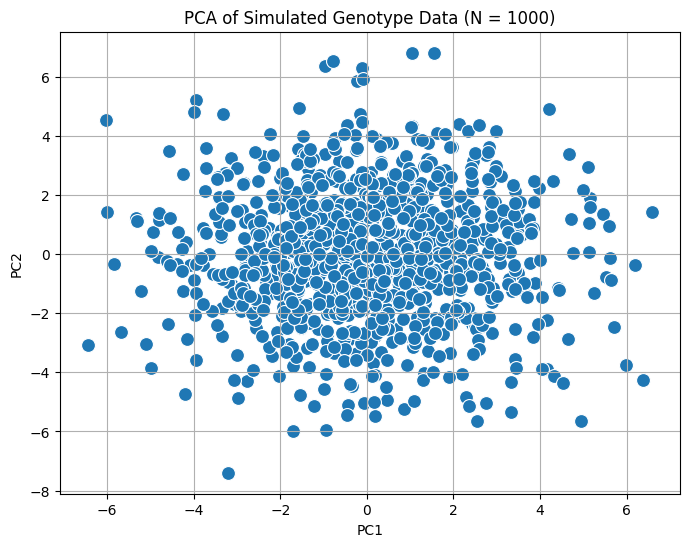

(1000, 4)
(1000,)
(3000, 3)
Original statistic (h2): 1.9776281091718223e-12


In [ ]:
main_permutation_test()